# Lab 3

__Team Members__
- Name 1: Jorge Olmos
- Name 2: Bosang Yun
- Name 3: Yucheol Shin
- Name 4: Siu Wai Yeung

# Content
* [Business Understanding](#business-understanding)
* [Data Understanding](#data-understanding)
    - [Part 1](#data-understanding-part1)
    - [Part 2](#data-understanding-part2)
* [Modeling Evaluation](#deployment)
    - [Train and Adjust Parameters](#train-adjust)
    - [Evaluate and Compare](#evaluate-compare)
    - [Visualize Resutls](#visualize-results)
    - [Summarize Rammifications](#summarize-rammifications)
* [Deployment](#deployment)
* [Exceptional Work](#exceptional-work)

# Importing Data and Cleaning

In [1]:
#==========================
#IF USING R, RUN THIS CODE
#==========================
# You will need to have R installed, as well as Rpy2 and the arules library
from rpy2.robjects.packages import importr
from rpy2 import robjects as robj

# this way we can write r code by simply writing %R
%load_ext rmagic
%load_ext rpy2.ipython 
# this enables the %R extension to iPython (does not work outside of the iPython shell)

# these packages will need to be installed
# open R and run 
#     install.package(arules)
#     install.package(arulesViz)

/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


## Loading library

In [3]:
%%R
library(dplyr)
library(arules)
library(arulesViz)
library(RColorBrewer)
library(ggplot2)

# Loading Data

In [4]:
%%R
bookings=read.csv("https://raw.githubusercontent.com/olmosjorge28/DS7331_ML1_ASSINGMENTS/main/hotel_bookings.csv")
# bookings


## Deleting unnecessary variables 

### todo exaplain why we're removing uncessary data

In [5]:
%%R
###################### Deleting unnecessary variables  ###########################
bookings <- subset(bookings, select = -c(agent, country,company,meal,arrival_date_week_number, reservation_status_date))

## Outliers

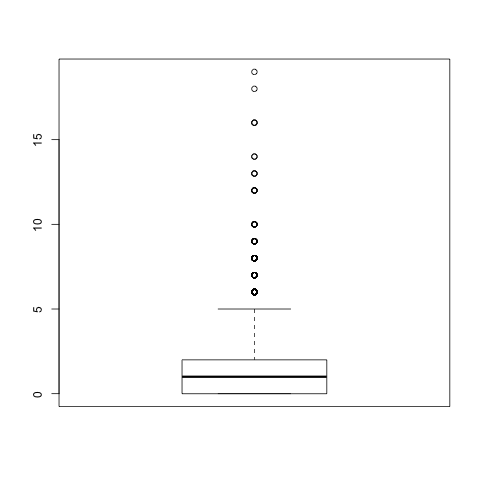

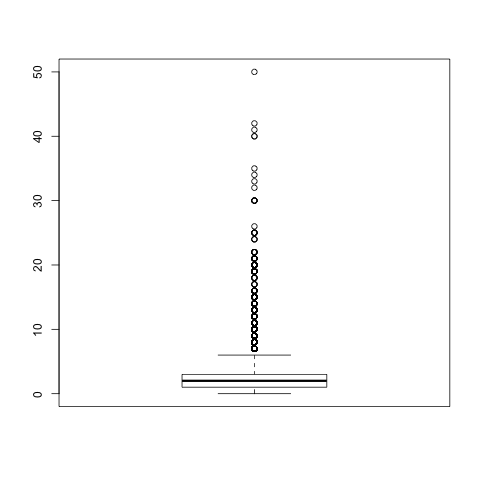

In [6]:
%%R
###################### Outliers ###########################
# Boxplot of stays_in_weekend_nights and stays_in_week_nights
boxplot(bookings$stays_in_weekend_nights) # Very skewed
boxplot(bookings$stays_in_week_nights)  # Very skewed


# Identifying outliers in stays_in_weekend_nights, stays_in_week 
outliers1 <- boxplot(bookings$stays_in_weekend_nights, plot=FALSE)$out
outliers2 <- boxplot(bookings$stays_in_week_nights, plot=FALSE)$out
outliers3 <- boxplot(bookings$adr, plot=FALSE)$out
outliers4 <- boxplot(bookings$lead_time, plot=FALSE)$out

length(outliers1) # Total of 265 outliers identified
length(outliers2)

bookings<- bookings[-which(bookings$stays_in_weekend_nights %in% outliers1),]
bookings<- bookings[-which(bookings$stays_in_week_nights %in% outliers2),]
bookings<- bookings[-which(bookings$adr %in% outliers3),]
bookings<- bookings[-which(bookings$lead_time %in% outliers4),]

In [7]:
%%R

summary(bookings$adr)

low_bookings <- bookings %>% filter(bookings$adr == "Low")

#head(bookings)
summ_adr <- summary(bookings$adr)
summ_lead_time <- summary(bookings$lead_time)
#summ_stays_in_weeks <- summary(bookings$stays_in_weeks)

adr_breaks = c(-Inf, summ_adr['1st Qu.'],summ_adr['3rd Qu.'],Inf )
lead_time_breaks = c(-Inf,summ_lead_time['1st Qu.'], summ_lead_time['3rd Qu.'], Inf)
#stays_in_weaks_breaks = c(-Inf,summ_stays_in_weeks['1st Qu.'], summ_stays_in_weeks['3rd Qu.'], Inf)


## Variable Imputation
    todo: describe work below

In [8]:
%%R 

################### Changing binary values to Yes and No #####################
bookings$is_canceled <- ifelse(bookings$is_canceled == 1, "Yes", "No")
bookings$is_repeated_guest <- ifelse(bookings$is_repeated_guest == 1, "Yes", "No")


bookings <- discretizeDF(bookings, methods = list(
lead_time = list(method = "Fixed", breaks = lead_time_breaks, 
   labels = c("Low", "Medium", "High")),
 adr = list(method = "Fixed", breaks = adr_breaks , 
   labels = c("Low", "Medium", "High")),
 stays_in_week_nights = list(method = "frequency", breaks = 3, 
   labels = c("Low", "Medium", "High"))
 ),
 default = list(method = "none")
 )



bookings$monthNum <- match(bookings$arrival_date_month, month.name)
bookings$fullDate <- as.Date(with(bookings, paste(arrival_date_year, monthNum, arrival_date_day_of_month,sep="-")), "%Y-%m-%d")
bookings$weekday <- weekdays(bookings$fullDate)
bookings <- subset(bookings, select=-c(monthNum,fullDate,arrival_date_day_of_month))
bookings$weekday

# Assigning seasons to arrival_date_month
bookings <- bookings %>% 
mutate(arrival_date_month = case_when(
    arrival_date_month %in% c('December','January', 'February') ~ 'Winter',
    arrival_date_month %in% c('March','April', 'May') ~ 'Spring',
    arrival_date_month %in% c( 'June','July','August') ~ 'Summer',
    arrival_date_month %in% c('September','October', 'November') ~ 'Fall'
    ))

summary(bookings$lead_time)

bookings<-subset(bookings, select=-(arrival_date_year))

# Factoring the dataframe
index <- 1:ncol(bookings)
bookings[ , index] <- lapply(bookings[ , index], as.factor)
str(bookings)

trans <- as(bookings, "transactions") # now the transaction data is ready for analysis
trans

'data.frame':	109425 obs. of  25 variables:
 $ hotel                         : Factor w/ 2 levels "City Hotel","Resort Hotel": 2 2 2 2 2 2 2 2 2 2 ...
 $ is_canceled                   : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 2 2 2 ...
 $ lead_time                     : Factor w/ 3 levels "Low","Medium",..: 3 1 1 1 1 1 1 2 2 2 ...
 $ arrival_date_month            : Factor w/ 4 levels "Fall","Spring",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ stays_in_weekend_nights       : Factor w/ 5 levels "0","1","2","3",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ stays_in_week_nights          : Factor w/ 3 levels "Low","Medium",..: 1 1 1 2 2 2 2 3 3 3 ...
 $ adults                        : Factor w/ 14 levels "0","1","2","3",..: 3 2 2 3 3 3 3 3 3 3 ...
 $ children                      : Factor w/ 4 levels "0","1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ babies                        : Factor w/ 5 levels "0","1","2","9",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ market_segment                : Factor w/ 8 levels "Aviation","Complementa

## Most Frequent Items

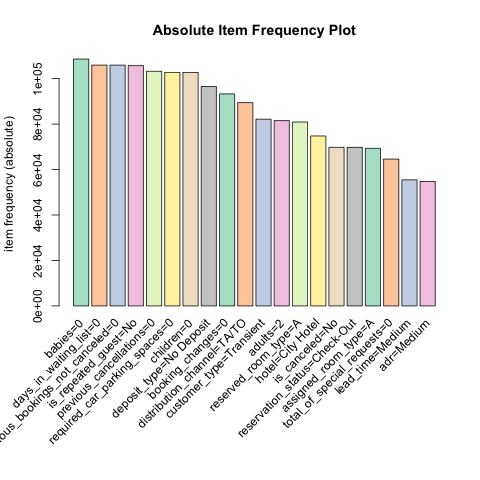

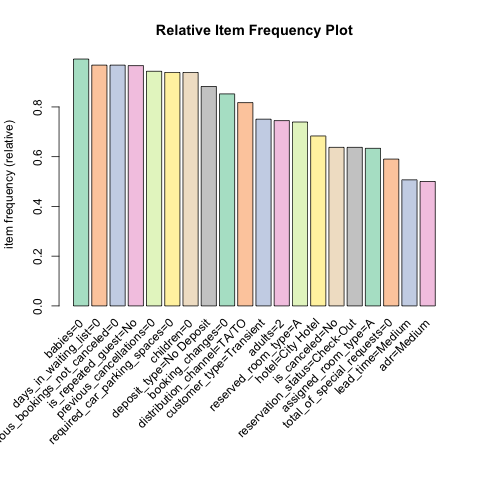

In [9]:
%%R 
itemFrequencyPlot(trans,topN=20,type="absolute",col=brewer.pal(8,'Pastel2'), main="Absolute Item Frequency Plot")
itemFrequencyPlot(trans,topN=20,type="relative",col=brewer.pal(8,'Pastel2'), main="Relative Item Frequency Plot")


# 1. Business Understanding  <a id='business-understanding'/>

## `Purpose of Data Selected`

We selected the hotel data set to investigate the associations for bookings that are canceled, the associations of booking city hotel vs a resort hotel, as well as what are the associations for an expensive vs inexpensive booking. To do so we will be exeucting an association rule learning alogirthm that could provide insights on what variables make it more likely for cancellaiton, which variables make it more likely for a customer to book a hotel in the city vs a resort hotel, and which variables make a booking more or less expensive for customer.

## `How will you measure the effectiveness of a good algorithm? `

We will be measuring the effectiveness of a rule by inspecting the confidence of each rule, or how likely is the the left hand side of the rule produced our desired right hand side. 

## `Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?`

# 2. Data Understanding <a id = '#data-understanding'/>

## Part 1 <a id ='#data-understanding-part1'/>

### `Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file
&emsp; The full description of the data can be found in https://www.sciencedirect.com/science/article/pii/S2352340918315191:


| Variable | Type | Description | Source/Engineering |
| --- | --- | --- | --- |
| ADR | Numeric | Average Daily Rate as defined by | BO, BL and TR / Calculated by dividing the sum of all lodging transactions by the total number of staying nights |
| Adults | Integer | Number of adults | BO and BL |
| Agent | Categorical | ID of the travel agency that made the bookinga | BO and BL |
| ArrivalDateDayOfMonth | Integer | Day of the month of the arrival date | BO and BL |
| ArrivalDateMonth | Categorical | Month of arrival date with 12 categories: “January” to “December”| BO and BL |
| ArrivalDateWeekNumber	| Integer | Week number of the arrival date | BO and BL |
| ArrivalDateYear | Integer | Year of arrival date | BO and BL |
| AssignedRoomType | Categorical | Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons | BO and BL |
| Babies | Integer | Number of babies | BO and BL |
| BookingChanges | Integer | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation | BO and BL/Calculated by adding the number of unique iterations that change some of the booking attributes, namely: persons, arrival date, nights, reserved room type or meal |
| Children | Integer | Number of children | BO and BL/Sum of both payable and non-payable children |
| Company | Categorical | ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons	BO and BL. |
| Country | Categorical | Country of origin. Categories are represented in the ISO 3155–3:2013 format [6] | BO, BL and NT |
| CustomerType | Categorical | Type of booking, assuming one of four categories: <br> Contract - when the booking has an allotment or other type of contract associated to it; <br> Group – when the booking is associated to a group; <br> Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; <br> Transient-party – when the booking is transient, but is associated to at least other transient booking <br> | BO and BL |
| DaysInWaitingList | Integer | Number of days the booking was in the waiting list before it was confirmed to the customer | BO/Calculated by subtracting the date the booking was confirmed to the customer from the date the booking entered on the PMS |
| DepositType | Categorical | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: <br> No Deposit – no deposit was made; <br> Non Refund – a deposit was made in the value of the total stay cost; <br> Refundable – a deposit was made with a value under the total cost of stay. | BO and TR/Value calculated based on the payments identified for the booking in the transaction (TR) table before the booking׳s arrival or cancellation date. |
| DistributionChannel | Categorical | Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators” | BO, BL and DC |
| IsCanceled | Categorical | Value indicating if the booking was canceled (1) or not (0) | BO |
| IsRepeatedGuest | Categorical | Value indicating if the booking name was from a repeated guest (1) or not (0) | BO, BL and C/ Variable created by verifying if a profile was associated with the booking customer. If so, and if the customer profile creation date was prior to the creation date for the booking on the PMS database it was assumed the booking was from a repeated guest |
| LeadTime | Integer | Number of days that elapsed between the entering date of the booking into the PMS and the arrival date | BO and BL/ Subtraction of the entering date from the arrival date |
| MarketSegment | Categorical | Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators” | BO, BL and MS |
| Meal | Categorical | Type of meal booked. | Categories are presented in standard hospitality meal packages: <br> Undefined/SC – no meal package; <br> BB – Bed & Breakfast; <br> HB – Half board (breakfast and one other meal – usually dinner); <br> FB – Full board (breakfast, lunch and dinner) | BO, BL and ML |
| PreviousBookingsNotCanceled | Integer | Number of previous bookings not cancelled by the customer prior to the current booking | BO and BL / In case there was no customer profile associated with the booking, the value is set to 0. Otherwise, the value is the number of bookings with the same customer profile created before the current booking and not canceled. |
| PreviousCancellations | Integer | Number of previous bookings that were cancelled by the customer prior to the current booking | BO and BL/ In case there was no customer profile associated with the booking, the value is set to 0. Otherwise, the value is the number of bookings with the same customer profile created before the current booking and canceled. |
| RequiredCardParkingSpaces | Integer | Number of car parking spaces required by the customer | BO and BL |
| ReservationStatus | Categorical | Reservation last status, assuming one of three categories: <br> Canceled – booking was canceled by the customer; <br> Check-Out – customer has checked in but already departed; <br> No-Show – customer did not check-in and did inform the hotel of the reason why | BO |
| ReservationStatusDate | Date | Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel | BO |
| ReservedRoomType | Categorical | Code of room type reserved. Code is presented instead of designation for anonymity reasons | BO and BL |
| StaysInWeekendNights | Integer | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel | BO and BL/ Calculated by counting the number of weekend nights from the total number of nights |
| StaysInWeekNights | Integer | Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel | BO and BL/Calculated by counting the number of week nights from the total number of nights |
| TotalOfSpecialRequests | Integer | Number of special requests made by the customer (e.g. twin bed or high floor) | BO and BL/Sum of all special requests |
<br>





### `Verify data quality`

#### `Missing values?`
Upon initial inspection of the 31 attributes, we noticed the following,
1. Total of 7 attributes appears to have some missing data.
We decided to replace the missing value “__nan__ and “__Undefined__” with __MODE__ as they appear to be accidental
2. We decided to __remove__ “__agent__” and “__company__” attributes as they do not provide any valuable information for analysis
3. we decided to replace '__Undefined__' with '__SC__' under Meal attribute as they are synonymous. 
4. We classify the non-categorical attributes that are above and below 1.5 times the interquartile range of the dataset as __outliers__. 

Below is a list of all the attributes with missing values and the counts:
* agent- 16340
* company- 112593
* children- 4
* country- 488
* market_segment - 2
* meal - 1169
* distribution_channel – 5

There's an association between the distribution channel type and the agent and company attributes. 
1. If the distribution channel is from a Traveling Agent (__TA__) or Tour Operator (__TO__), then the agency company is supplied in the agent column. 
2. if the distribution channel is __Corporate__, then the company associated with the booking is populated under the company attribute. 
3. If the distribution is neither __Corporate__, __TA__ or __TO__ than both the __agent and company__ attributes will be __null__. 
4. For the meal attribute during our data investigation, we have found out that '__Undefined__' and '__SC__' are synonymous so we have decided to __replace__ '__Undefined__' with '__SC__'. 


To simplify our data exploration, we decided to __remove__ the __agent and company__ attributes as they don't provide any additional information beyond what already is provided in the distribution channel. 
Data cleaning for the above attributes will be followed. 

#### `Outliers`
##### Outlier removal
- First we decided to take a look the simple statistics of the continuous variables to see if they make sense. 
- __adr__ and __lead_time__ had minimum and maximum values that appear as data entry error.  
- __stays_in_week_nights__ and __stays_in_weekend_nights__ had too extreme maximum values when there are only seven days in a week. 
- __days_in_waiting_list__, __total_of_special_requests__ and __required_car_parking_spaces__ had reasonable data distribution. 
- After determining that the 4 continuous features(adr, lead_time, stays_week_nights, stays_weekend_nights) have extreme outliers, the 25% and 75% interquartile range (IQR) was utilized in order to identify and remove the outliers from the dataset. 
- Outliers that are positioned at above and below the 1.5 times the upper and lower limit of IQR are removed

## Part 2 <a id ='#data-understanding-part2'/>

#### `Market Segment`

Market segmentation involves analyzing the target markets for the hotel industry and segmenting them based on the pricing sensitivity and booking behaviors. Understanding market segment is very important part of understanding customer needs and it leads to better insights and predictibility of the model.

Online tour agents heavily accounted for the market segment. They were more than double the number of offline TA/TO, which was the second largest market segment. We will delve into this attribute in relation to other key attributes(For example, it is assumed that online/offline Tour agents have better ADR than other market segments due to their ability to book in bulk.)

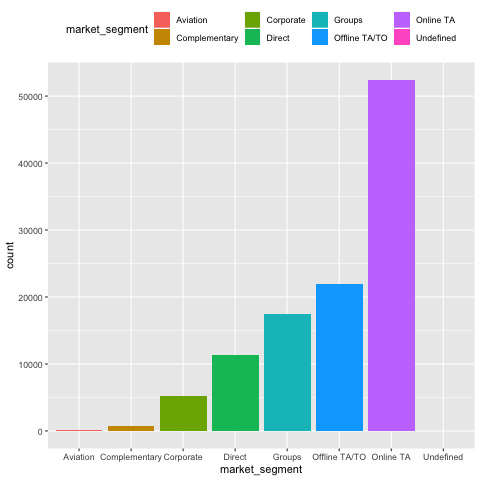

In [10]:
%%R
g <- ggplot(bookings, aes(market_segment))
g + geom_bar(aes(fill=market_segment)) + theme(legend.position = "top")

#### `Customer Type`

Customer Type is type of booking with four categories.
 - Contract: when the booking has an allotment or other type of contract associated to it
 - Group: when the booking is associated to a group
 - Transient: when the booking is not part of a group or contract, and is not associated to other transient booking
 - Transient-party: when the booking is transient, but is associated to at least other transient booking

We focused on the customer type in order to understand which attributes of the hotel and its booking characteristics related to the each customer. Transient party guests usually are short-term stay with less than 10 nights and are the most dominant customer type. It is a bit surprisng to see the group and contract category being not as outstanding given that the dominant market segment for tour agents.

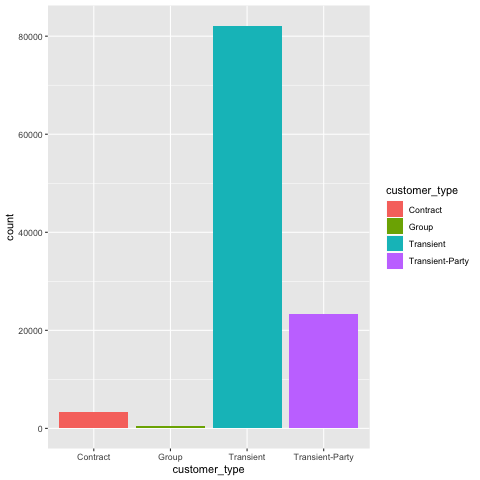

In [11]:
%%R
g <- ggplot(bookings, aes(customer_type))
g + geom_bar(aes(fill=customer_type))

#### `Seasonality`

Since Apriori needs a categorical data and we need seasonal information rather than time series data for understanding the association, we have converted our month data into the seasonality. For every quarter, we divided up into the season. During the peak seaon, summer, there are more numbers of high adr. And during off-season, winter, there are more number of low adr.

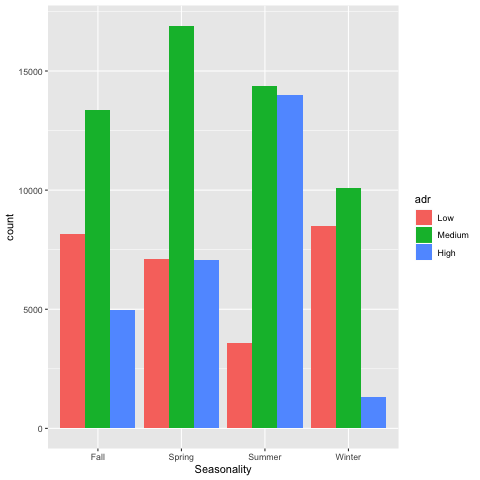

In [12]:
%%R
g <- ggplot(bookings, aes(arrival_date_month))
g + geom_bar(aes(fill=adr), position = "dodge") + xlab("Seasonality")

#### `Day of the Week`

Since we need a categorical variable for the apriori, we converted the arrival_date_of_month into the day of the week. With weekday conversion, we can look for the association of weekday to the target variables, such as ADR or Cancellation. From the below bar chart, there are more number of booking during Thursday and Friday. Both numbers of medium and high adr booking are lowest at Thursday, and they gradually increases untill Friday then it decreases untill Sunday.

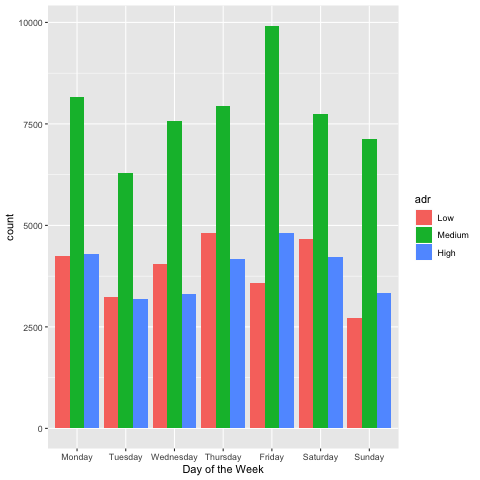

In [15]:
%%R
level_order <- c('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
g <- ggplot(bookings, aes(factor(weekday, level = level_order)))
g + geom_bar(aes(fill=adr), position = "dodge") + xlab("Day of the Week")

#### `ADR and Cancellation`

Two of another key features is ADR and is_cancellation which we can look into the assocation to these two targets from other attributes. We can see there are more number of non cancellation than the cancelled booking. Also we can see that there are more number of cheap ADR on non-canceled booking and there are more number of medium and high ADR on canceled booking.

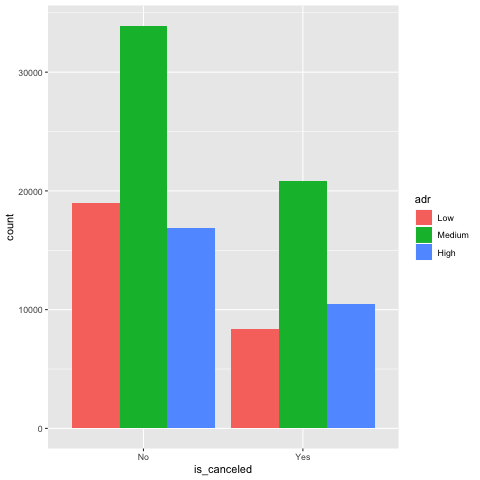

In [16]:
%%R
g <- ggplot(bookings, aes(is_canceled))
g + geom_bar(aes(fill = adr), position='dodge')

# 3. Modeling and Evaluation

## Train and adjust parameters

## Rules for LHS (All the variables) vs RHS(ADR)

In [19]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

NameError: name 'plt' is not defined

In [17]:
%%R
rules <- apriori(trans,parameter=list(minlen=2,maxlen=5, support=.005, confidence=.9), control = list(verbose=F),appearance = list(rhs=c("adr=Low","adr=Medium","adr=High"),default="lhs"))
summary(rules)
rules_lift <- sort(rules, by="lift")
rules_pruned <- rules_lift[!is.redundant(rules_lift, measure="lift")]
#rules_pruned <- rules_pruned[quality(rules_pruned)$lift > 2.95]

#inspect(sort(rules, by = 'lift')[1:10])

#length(rules_pruned)
#inspect(rules_pruned, by="lift")



R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



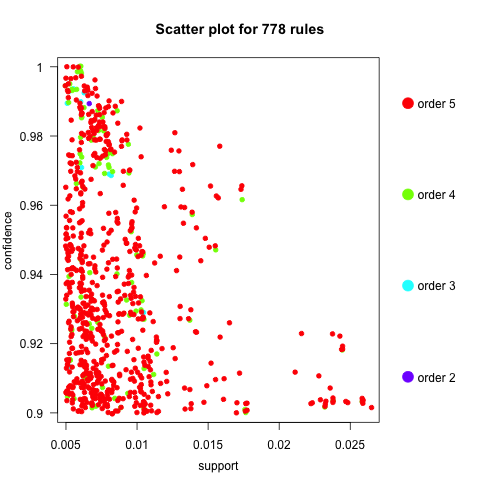

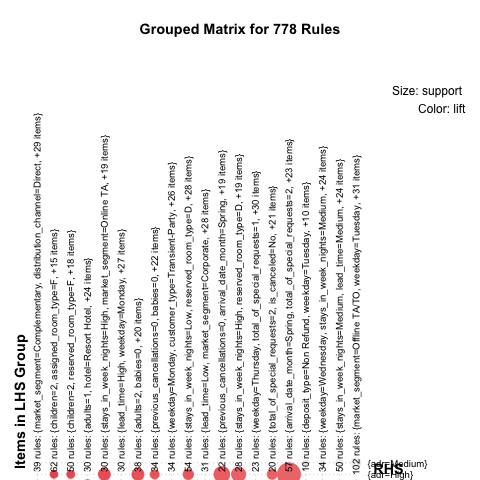

In [22]:
%%R
plot(rules_pruned, method="two-key plot") # The two-key plot uses support and confidence on x and y-axis respectively. It uses order for coloring. The order is the number of items in the rule.
plot(rules_pruned, method="grouped")
#plot(rules_pruned, method="graph")
#plot(rules_pruned, method="grouped matrix")
#plot(rules_pruned, method="matrix3D")
#plot(rules_pruned, method="paracoord", control = list(reorder = TRUE))

## Rules for LHS(All the variables) vs RHS(is_canceled)

R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



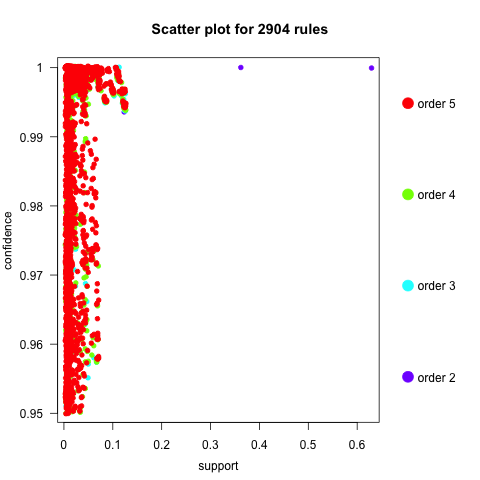

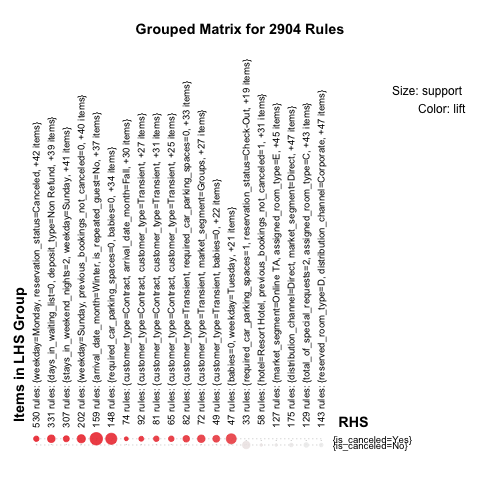

In [64]:
%%R
rules <- apriori(trans,parameter=list(minlen=2, maxlen=5,support=.005, confidence=.95), control = list(verbose=F),appearance = list(rhs=c("is_canceled=No","is_canceled=Yes"),default="lhs"))

summary(rules)
rules_lift <- sort(rules, by="lift")
rules_pruned <- rules_lift[!is.redundant(rules_lift, measure="lift")]
#length(rules_pruned)
#inspect(rules_pruned,by="lift")

# Plots
plot(rules_pruned, method="two-key plot") # The two-key plot uses support and confidence on x and y-axis respectively. It uses order for coloring. The order is the number of items in the rule.
plot(rules_pruned, method="grouped")
# plot(rules_pruned, method="graph")
# plot(rules_pruned, method="grouped matrix")
# plot(rules_pruned, method="matrix3D")
# plot(rules_pruned, method="paracoord")

IGRAPH 3f7f996 DN-- 24 33 -- 
+ attr: name (v/c), label (v/c), support (v/n), confidence (v/n),
| coverage (v/n), lift (v/n), count (v/n), order (v/n)
+ edges from 3f7f996 (vertex names):
 [1] 336   ->assoc1  334   ->assoc2  59    ->assoc3  316   ->assoc3 
 [5] 59    ->assoc4  187   ->assoc4  187   ->assoc5  318   ->assoc5 
 [9] 1     ->assoc6  47    ->assoc6  316   ->assoc6  47    ->assoc7 
[13] 59    ->assoc7  338   ->assoc7  7     ->assoc8  59    ->assoc8 
[17] 338   ->assoc8  54    ->assoc9  59    ->assoc9  339   ->assoc9 
[21] 47    ->assoc10 59    ->assoc10 341   ->assoc10 assoc1->4      
[25] assoc2->4       assoc3->4       assoc4->4       assoc5->4      
+ ... omitted several edges


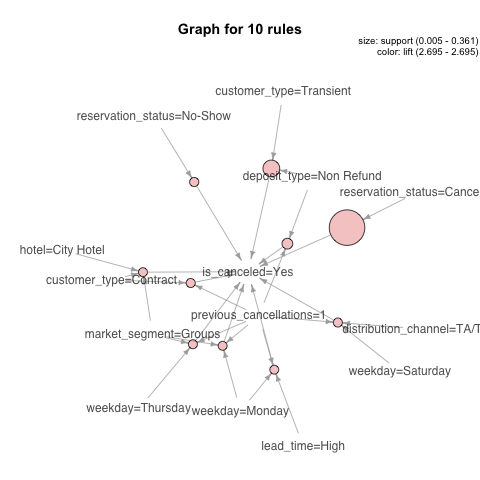

In [32]:
%%R
library(htmlwidgets)
library(IRdisplay)
library(plotly)


top10Rules <- head(rules_pruned, n = 10, by = "confidence")
p <- plot(top10Rules, method = "graph")
#html_plot(p,out=paste0("demo",".html"))
#saveWidget(p, 'demo.html', selfcontained=FALSE)
p
#saveAsGraph(head(rules_pruned, n = 100, by = "lift"), file = "rules.graphml")

## Rules for LHS(All the variables) vs RHS(Hotel - Resort)

R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



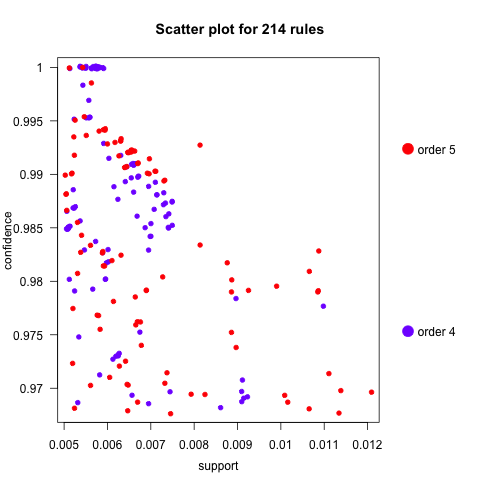

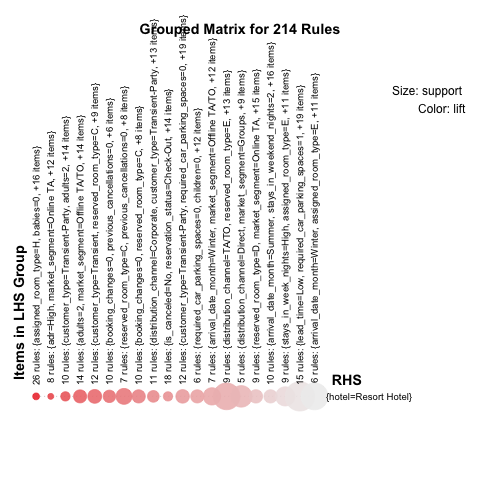

In [34]:
%%R
rules <- apriori(trans,parameter=list(minlen=4,maxlen=5, support=.005, confidence=.9), control = list(verbose=F),appearance = list(rhs=c("hotel=Resort Hotel"),default="lhs"))

summary(rules)
rules_lift <- sort(rules, by="lift")
# plot(rules_lift, method="grouped matrix")
rules_pruned <- rules_lift[!is.redundant(rules_lift, measure="lift")]
rules_pruned <- rules_pruned[quality(rules_pruned)$lift>3.0]
summary(rules_pruned)

#length(rules_pruned)
#inspect(rules_pruned, by="lift")


# Plots
plot(rules_pruned, method="two-key plot") # The two-key plot uses support and confidence on x and y-axis respectively. It uses order for coloring. The order is the number of items in the rule.
plot(rules_pruned, method="grouped")
#plot(rules_pruned, method="graph")
#plot(rules_pruned, method="grouped matrix")
#plot(rules_pruned, method="matrix3D")
#plot(rules_pruned, method="paracoord", control = list(reorder = TRUE))

## Rules for LHS(Cancellation related variables) vs RHS(Hotel - Resort)


R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



     lhs                                 rhs                      support confidence    coverage     lift count
[1]  {reserved_room_type=H}           => {hotel=Resort Hotel} 0.005294814  1.0000000 0.005294814 4.145264   228
[2]  {assigned_room_type=H}           => {hotel=Resort Hotel} 0.005434152  1.0000000 0.005434152 4.145264   234
[3]  {reserved_room_type=C,                                                                                    
      customer_type=Transient,                                                                                 
      adr=High}                       => {hotel=Resort Hotel} 0.005457374  1.0000000 0.005457374 4.145264   235
[4]  {previous_cancellations=0,                                                                                
      reserved_room_type=C,                                                                                    
      adr=High}                       => {hotel=Resort Hotel} 0.005666380  1.0000000 0.005666380 4.14526

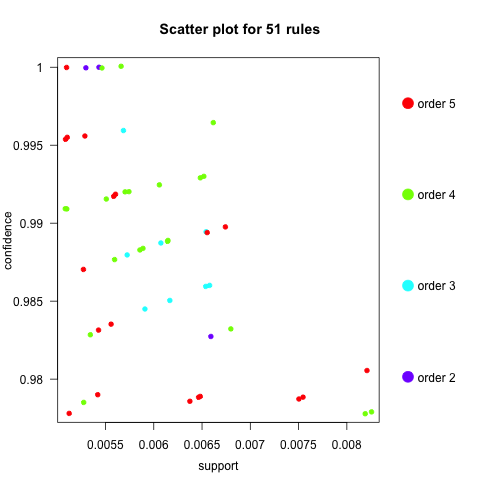

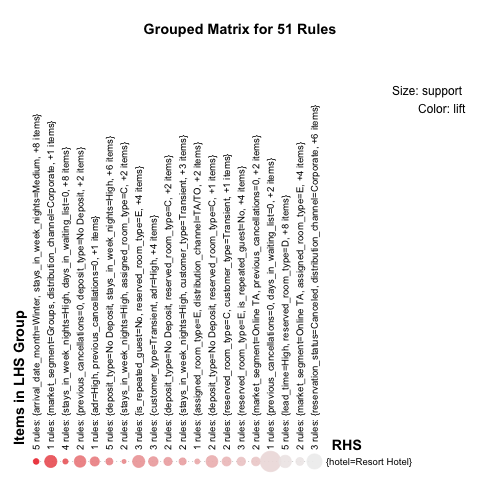

In [46]:
%%R
trans_cancel <- as(bookings[bookings$is_canceled == "Yes", ], "transactions")

rules <- apriori(trans_cancel,parameter=list(minlen=2,maxlen=5, support=.005, confidence=.9), control = list(verbose=F),appearance = list(rhs=c("hotel=Resort Hotel"),default="lhs"))

summary(rules)
rules_lift <- sort(rules, by="lift")
# plot(rules_lift, method="grouped matrix")
rules_pruned <- rules_lift[!is.redundant(rules_lift, measure="lift")]
rules_pruned <- rules_pruned[quality(rules_pruned)$lift>4.05 ]
summary(rules_pruned)

#length(rules_pruned)
#inspect(rules_pruned, by="lift")


# Plots
plot(rules_pruned, method="two-key plot") # The two-key plot uses support and confidence on x and y-axis respectively. It uses order for coloring. The order is the number of items in the rule.
plot(rules_pruned, method="grouped")
# plot(rules_pruned, method="graph")
# plot(rules_pruned, method="grouped matrix")
# plot(rules_pruned, method="matrix3D")
# plot(rules_pruned, method="paracoord", control = list(reorder = TRUE))
top10Rules <- head(rules_pruned, n = 10, by = "confidence")
inspect(top10Rules)

## Rules for LHS(All the variables) vs RHS(Hotel - City)

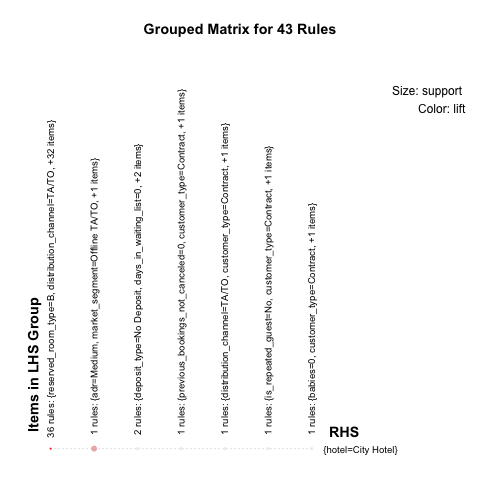

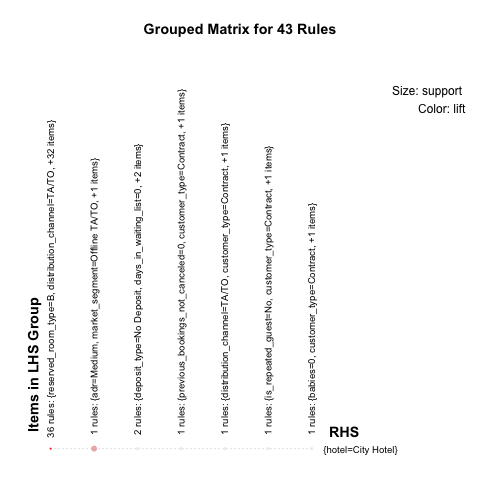

In [38]:
%%R
rules <- apriori(trans,parameter=list(minlen=4,maxlen=5, support=.005, confidence=.9), control = list(verbose=F),appearance = list(rhs=c("hotel=City Hotel"),default="lhs"))

summary(rules)
rules_lift <- sort(rules, by="lift")
# plot(rules_lift, method="grouped matrix")
rules_pruned <- rules_lift[!is.redundant(rules_lift, measure="lift")]
rules_pruned <- rules_pruned[quality(rules_pruned)$lift>1.475]
summary(rules_pruned)

#length(rules_pruned)
#inspect(rules_pruned, by="lift")


# Plots

plot(rules_pruned, method="grouped matrix")
plot(rules_pruned, method="grouped")
# plot(rules_pruned, method="graph")
# plot(rules_pruned, method="matrix3D")
# plot(rules_pruned, method="two-key plot") # The two-key plot uses support and confidence on x and y-axis respectively. It uses order for coloring. The order is the number of items in the rule.
# plot(rules_pruned, method="paracoord", control = list(reorder = TRUE))

## Rules for LHS(Cancellation related variables) vs RHS(Hotel - City)

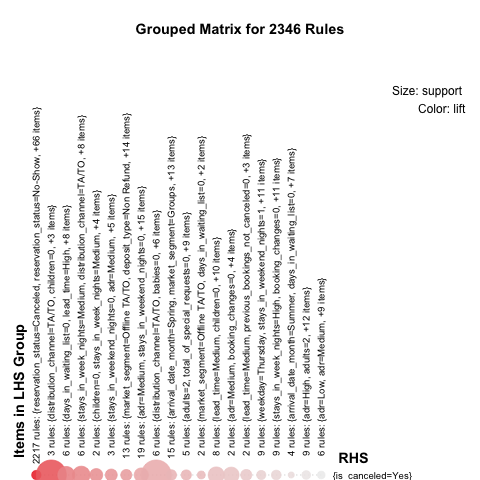

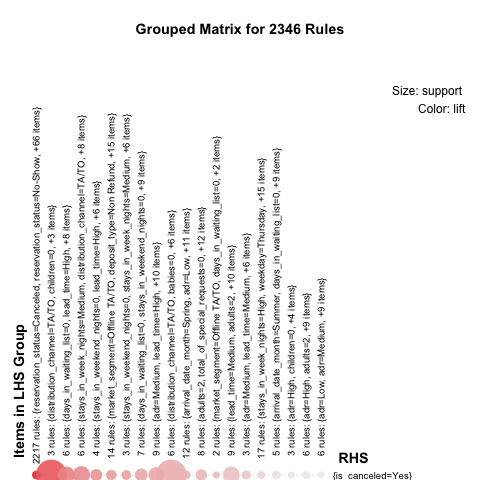

In [39]:
%%R
trans_cancel <- as(bookings[bookings$hotel == "City Hotel", ], "transactions")

rules <- apriori(trans_cancel,parameter=list(minlen=4,maxlen=5, support=.005, confidence=.9), control = list(verbose=F),appearance = list(rhs=c("is_canceled=Yes"),default="lhs"))

summary(rules)
rules_lift <- sort(rules, by="lift")
# plot(rules_lift, method="grouped matrix")
rules_pruned <- rules_lift[!is.redundant(rules_lift, measure="lift")]
rules_pruned <- rules_pruned[quality(rules_pruned)$lift>2.40507]
summary(rules_pruned)

#length(rules_pruned)
#inspect(rules_pruned, by="lift")

# Plots
plot(rules_pruned, method="grouped matrix")
plot(rules_pruned, method="grouped")
# plot(rules_pruned, method="graph")
# plot(rules_pruned, method="matrix3D")
# plot(rules_pruned, method="two-key plot") # The two-key plot uses support and confidence on x and y-axis respectively. It uses order for coloring. The order is the number of items in the rule.
# plot(rules_pruned, method="paracoord", control = list(reorder = TRUE))

## Rules for LHS(All the variables) vs RHS(Hotel - Resort)

      lhs                                   rhs                      support confidence    coverage     lift count
[1]   {assigned_room_type=H,                                                                                      
       deposit_type=No Deposit,                                                                                   
       customer_type=Transient}          => {hotel=Resort Hotel} 0.005472440  1.0000000 0.005472440 3.100494   635
[2]   {previous_cancellations=0,                                                                                  
       assigned_room_type=H,                                                                                      
       customer_type=Transient}          => {hotel=Resort Hotel} 0.005437968  1.0000000 0.005437968 3.100494   631
[3]   {is_repeated_guest=No,                                                                                      
       assigned_room_type=H,                                                    

[48]  {is_repeated_guest=No,                                                                                      
       previous_cancellations=0,                                                                                  
       reserved_room_type=C}             => {hotel=Resort Hotel} 0.007325313  0.9883721 0.007411493 3.064442   850
[49]  {reserved_room_type=C,                                                                                      
       assigned_room_type=C,                                                                                      
       days_in_waiting_list=0}           => {hotel=Resort Hotel} 0.007127098  0.9880526 0.007213279 3.063451   827
[50]  {reserved_room_type=C,                                                                                      
       assigned_room_type=C,                                                                                      
       deposit_type=No Deposit}          => {hotel=Resort Hotel} 0.007109862  0.

       assigned_room_type=C,                                                                                      
       adr=Low}                          => {hotel=Resort Hotel} 0.005351787  0.9748823 0.005489676 3.022617   621
[96]  {stays_in_weekend_nights=2,                                                                                 
       previous_cancellations=0,                                                                                  
       assigned_room_type=C}             => {hotel=Resort Hotel} 0.006265297  0.9732262 0.006437657 3.017482   727
[97]  {stays_in_weekend_nights=2,                                                                                 
       is_repeated_guest=No,                                                                                      
       assigned_room_type=C}             => {hotel=Resort Hotel} 0.006239443  0.9731183 0.006411803 3.017148   724
[98]  {stays_in_weekend_nights=2,                                               

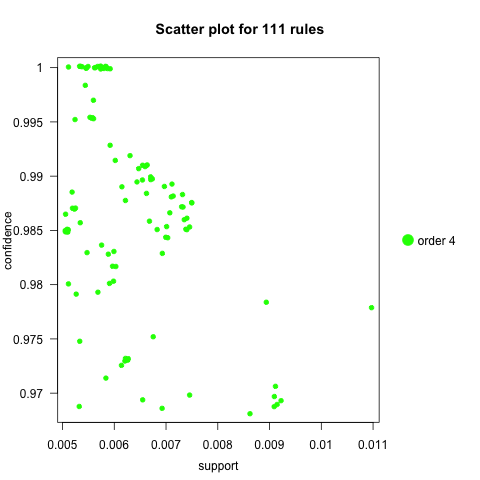

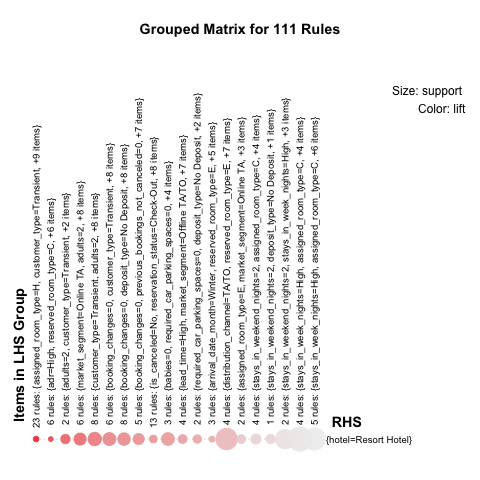

In [40]:
%%R
rules <- apriori(trans,parameter=list(minlen=4,maxlen=5, support=.005, confidence=.9), control = list(verbose=F),appearance = list(rhs=c("hotel=Resort Hotel"),default="lhs"))

summary(rules)
rules_lift <- sort(rules, by="lift")
# plot(rules_lift, method="grouped matrix")
rules_pruned <- rules_lift[!is.redundant(rules_lift, measure="lift")]
rules_pruned <- rules_pruned[quality(rules_pruned)$lift>3.0]
summary(rules_pruned)

length(rules_pruned)
inspect(rules_pruned, by="lift")


# Plots
plot(rules_pruned, method="two-key plot") # The two-key plot uses support and confidence on x and y-axis respectively. It uses order for coloring. The order is the number of items in the rule.
plot(rules_pruned, method="grouped")
# plot(rules_pruned, method="graph")
# plot(rules_pruned, method="grouped matrix")
# plot(rules_pruned, method="matrix3D")
# plot(rules_pruned, method="paracoord", control = list(reorder = TRUE))

## Rules for LHS(Cancellation related variables) vs RHS(customer_type - Transient Party(Family, friends))


R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



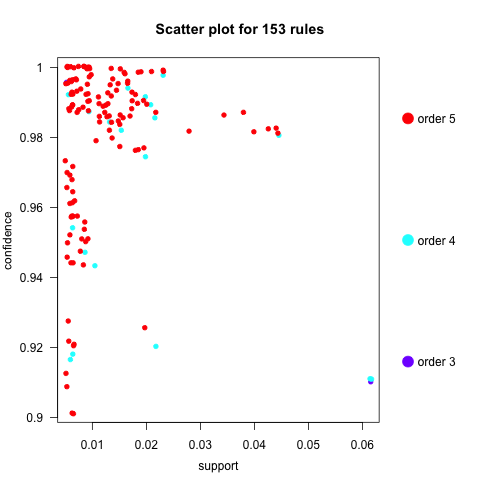

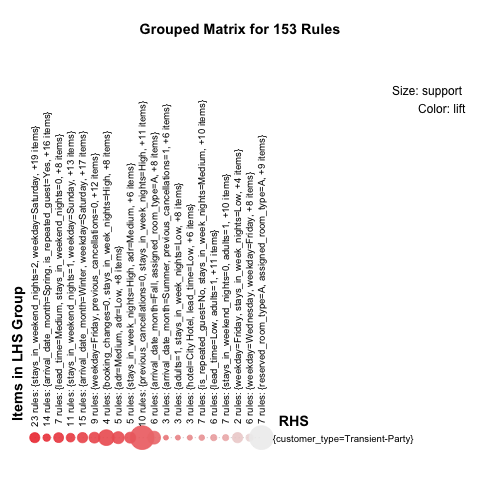

In [41]:
%%R
trans_cancel <- as(bookings[bookings$is_canceled == "Yes", ], "transactions")

rules <- apriori(trans_cancel,parameter=list(minlen=2,maxlen=5, support=.005, confidence=.9), control = list(verbose=F),appearance = list(rhs=c("customer_type=Contract", "customer_type=Group", "customer_type=Transient","customer_type=Transient-Party"),default="lhs"))

summary(rules)
rules_lift <- sort(rules, by="lift")
# plot(rules_lift, method="grouped matrix")
rules_pruned <- rules_lift[!is.redundant(rules_lift, measure="lift")]
rules_pruned <- rules_pruned[quality(rules_pruned)$lift>3 & quality(rules_pruned)$lift<30 ]
summary(rules_pruned)
#length(rules_pruned)
#inspect(rules_pruned, by="lift")


# Plots
plot(rules_pruned, method="two-key plot") # The two-key plot uses support and confidence on x and y-axis respectively. It uses order for coloring. The order is the number of items in the rule.
plot(rules_pruned, method="grouped")
# plot(rules_pruned, method="graph")
# plot(rules_pruned, method="grouped matrix")
# plot(rules_pruned, method="matrix3D")
# plot(rules_pruned, method="paracoord", control = list(reorder = TRUE))

## Rules for LHS(Cancellation related variables) vs RHS(customer_type - Contract (Company or Government))


R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



     lhs                              rhs                          support confidence    coverage     lift count
[1]  {stays_in_week_nights=Medium,                                                                              
      is_repeated_guest=No,                                                                                     
      previous_cancellations=1,                                                                                 
      weekday=Thursday}            => {customer_type=Contract} 0.007942221  0.8260870 0.009614268 29.89255   342
[2]  {stays_in_week_nights=Low,                                                                                 
      market_segment=Groups,                                                                                    
      previous_cancellations=1,                                                                                 
      weekday=Monday}              => {customer_type=Contract} 0.007895776  0.6813627 0.01158821

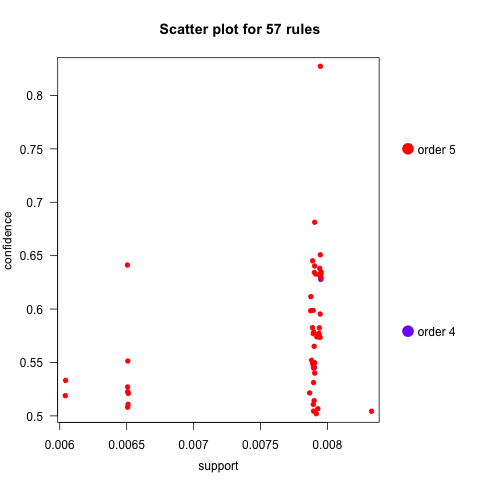

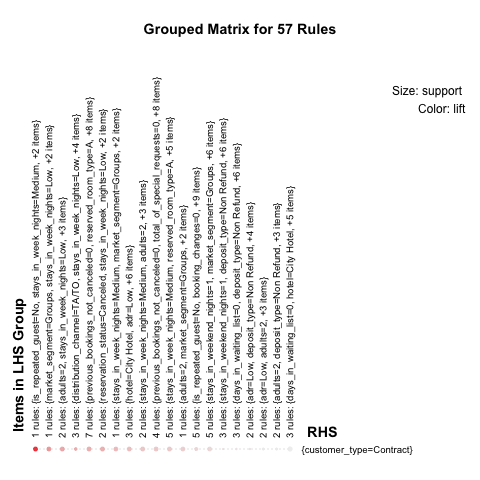

In [48]:
%%R
trans_cancel <- as(bookings[bookings$is_canceled == "Yes", ], "transactions")

rules <- apriori(trans_cancel,parameter=list(minlen=2,maxlen=5, support=.005, confidence=.5), control = list(verbose=F),appearance = list(rhs=c("customer_type=Contract"),default="lhs"))

summary(rules)
rules_lift <- sort(rules, by="lift")
# plot(rules_lift, method="grouped matrix")
rules_pruned <- rules_lift[!is.redundant(rules_lift, measure="lift")]
rules_pruned <- rules_pruned[quality(rules_pruned)$lift>3 & quality(rules_pruned)$lift<30 ]
summary(rules_pruned)
#length(rules_pruned)
#inspect(rules_pruned, by="lift")


# Plots
plot(rules_pruned, method="two-key plot") # The two-key plot uses support and confidence on x and y-axis respectively. It uses order for coloring. The order is the number of items in the rule.
plot(rules_pruned, method="grouped")
# plot(rules_pruned, method="graph")
# plot(rules_pruned, method="grouped matrix")
# plot(rules_pruned, method="matrix3D")
# plot(rules_pruned, method="paracoord", control = list(reorder = TRUE))
inspect(head(rules_pruned, n = 10, by = "confidence"))

## Rules for LHS(Time related variables) vs RHS(ADR)

    lhs                                           rhs       support    
[1] {stays_in_weekend_nights=0,weekday=Monday} => {adr=Low} 0.001034162
    confidence coverage    lift     count
[1] 1          0.001034162 3.000129 120  


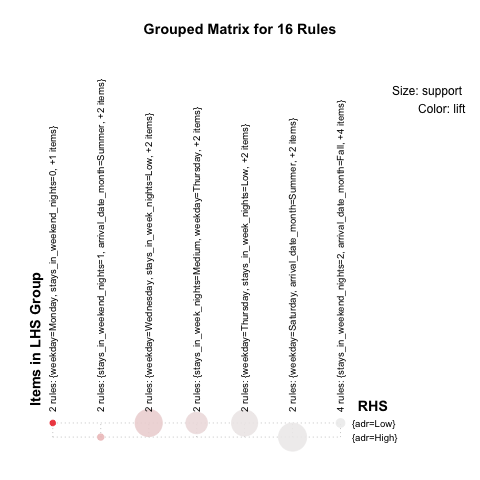

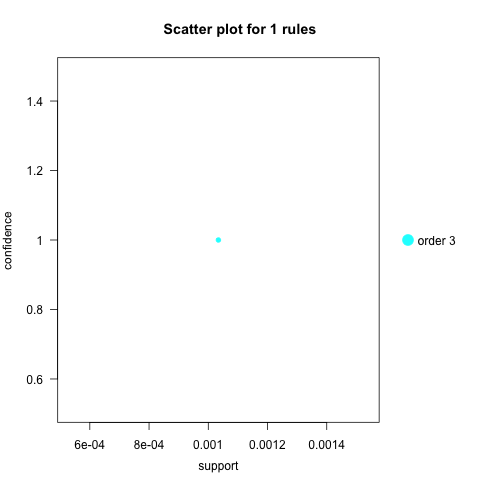

In [56]:
%%R

rules <- apriori(trans,parameter=list(minlen=2,maxlen=5, support=.0005, confidence=.7), control = list(verbose=F),appearance = list(rhs=c("adr=Low","adr=Medium","adr=High"), lhs=c("stays_in_week_nights=Low","stays_in_week_nights=Medium","stays_in_week_nights=High", "stays_in_weekend_nights=0","stays_in_weekend_nights=1", "stays_in_weekend_nights=2",  "stays_in_weekend_nights=3","stays_in_weekend_nights=4", "arrival_date_month=Spring","arrival_date_month=Summer","arrival_date_month=Fall","arrival_date_month=Winter","weekday=Monday", "weekday=Tuesday","weekday=Wednesday","weekday=Thursday","weekday=Friday","weekday=Saturday","weekday=Sunday"),default="none"))
                                                                                                              
                                                                                                              
summary(rules)
plot(rules, method="grouped matrix")

rules_lift <- sort(rules, by="lift")
rules_pruned <- rules_lift[!is.redundant(rules_lift, measure="lift")]
rules_pruned <- rules_pruned[quality(rules_pruned)$lift > 2.95]

 
length(rules_pruned)  
#inspect(rules_pruned, by="lift")


# Plots
plot(rules_pruned, method="two-key plot") # The two-key plot uses support and confidence on x and y-axis respectively. It uses order for coloring. The order is the number of items in the rule.
#plot(rules_pruned, method="grouped")
# plot(rules_pruned, method="graph")
#plot(rules_pruned, method="grouped matrix")
# plot(rules_pruned, method="matrix3D")
# plot(rules_pruned, method="paracoord", control = list(reorder = TRUE))
inspect(head(rules_pruned, n = 10, by = "confidence"))


## Rules for LHS(Reservation type) vs RHS(ADR)


Itemsets in Antecedent (LHS)
 [1] "{hotel=City Hotel,market_segment=Groups,customer_type=Contract}"                                   
 [2] "{market_segment=Complementary,customer_type=Transient}"                                            
 [3] "{hotel=City Hotel,market_segment=Online TA,reserved_room_type=F,customer_type=Transient}"          
 [4] "{market_segment=Complementary}"                                                                    
 [5] "{hotel=City Hotel,market_segment=Online TA,distribution_channel=TA/TO,reserved_room_type=F}"       
 [6] "{hotel=City Hotel,market_segment=Online TA,reserved_room_type=F}"                                  
 [7] "{hotel=City Hotel,distribution_channel=TA/TO,reserved_room_type=F,customer_type=Transient}"        
 [8] "{hotel=City Hotel,distribution_channel=TA/TO,reserved_room_type=F}"                                
 [9] "{market_segment=Groups,reserved_room_type=A,customer_type=Contract}"                               
[10] "{market_seg

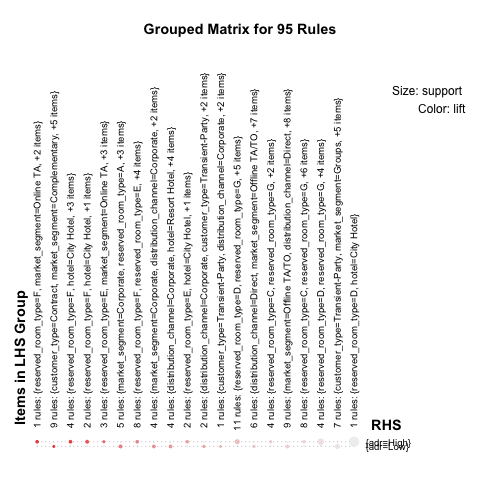

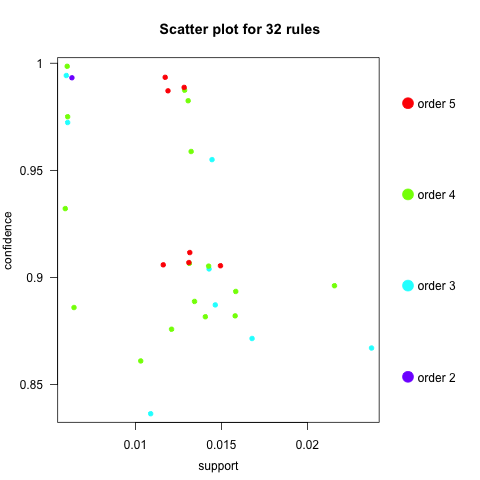

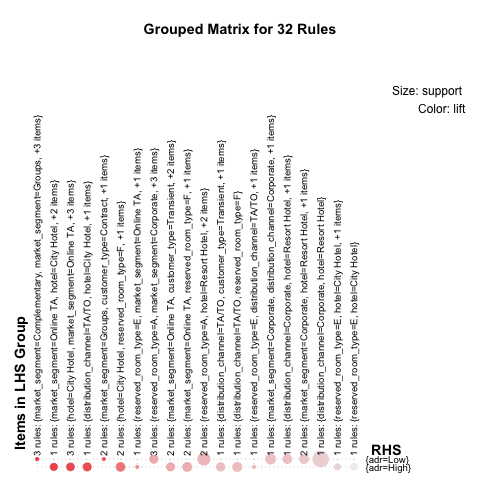

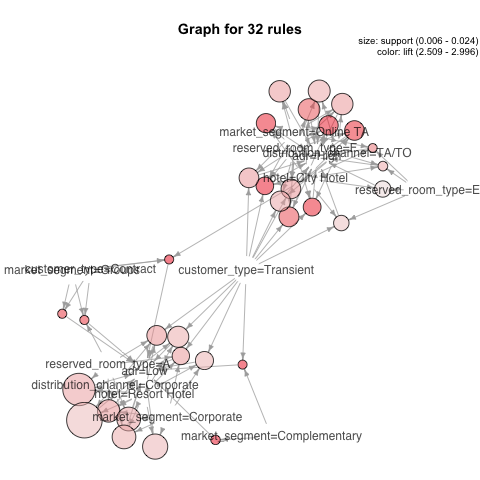

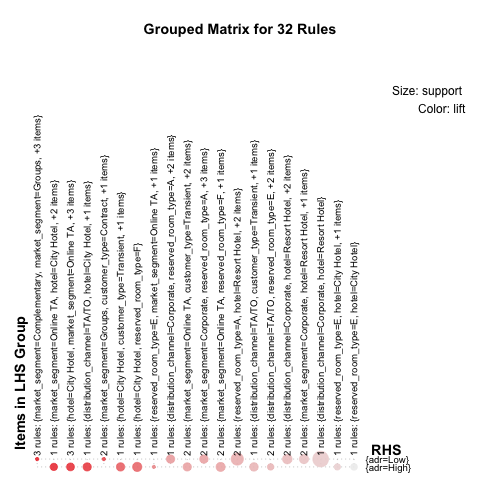

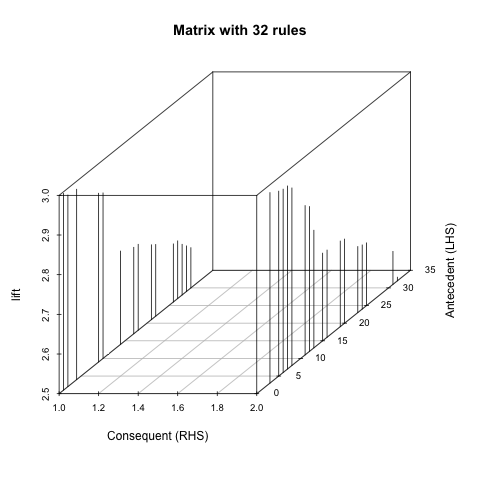

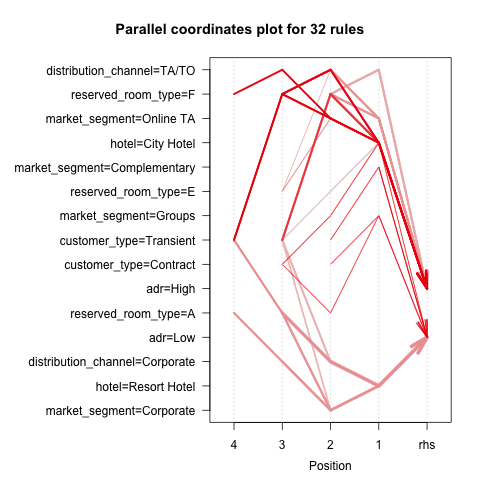

In [70]:
%%R
rules <- apriori(trans,parameter=list(minlen=2,maxlen=5, support=.005, confidence=.7), control = list(verbose=F),appearance = list(rhs=c("adr=Low","adr=Medium","adr=High"), lhs=c("market_segment=Aviation","market_segment=Complementary", "market_segment=Corporate", "market_segment=Direct", "market_segment=Groups", "market_segment=Offline TA/TO", "market_segment=Online TA", "customer_type=Contract", "customer_type=Group", "customer_type=Transient","customer_type=Transient-Party","reserved_room_type=A","reserved_room_type=B","reserved_room_type=C","reserved_room_type=D","reserved_room_type=E","reserved_room_type=F", "reserved_room_type=G", "reserved_room_type=H", "reserved_room_type=L", "reserved_room_type=P", "distribution_channel=Corporate","distribution_channel=Direct", "distribution_channel=GDS", "distribution_channel=TA/TO", "hotel=Resort Hotel","hotel=City Hotel"),default="none"))
                                                                                                          
                                                                                                           
summary(rules)
plot(rules, method="grouped matrix")

rules_lift <- sort(rules, by="lift")
rules_pruned <- rules_lift[!is.redundant(rules_lift, measure="lift")]
rules_pruned <- rules_pruned[quality(rules_pruned)$lift > 2.5]

length(rules_pruned)
#inspect(rules_pruned, by="lift")


# Plots
plot(rules_pruned, method="two-key plot") # The two-key plot uses support and confidence on x and y-axis respectively. It uses order for coloring. The order is the number of items in the rule.
plot(rules_pruned, method="grouped")
plot(rules_pruned, method="graph")
plot(rules_pruned, method="grouped matrix")
plot(rules_pruned, method="matrix3D")
plot(rules_pruned, method="paracoord", control = list(reorder = TRUE))
inspect(head(rules_pruned, n = 10, by = "confidence"))

## Evaluate and Compare

In [51]:
# Do same thing, getting only the maximal sets
%R is_max <- isets[is.maximal(isets)]
%R inspect(head(sort(is_max, by="support")))
%R length(is_max)

    items                                   support transIdenticalToItemsets  count
[1] {children=[0,10],                                                              
     babies=[0,10],                                                                
     meal=[0,3],                                                                   
     distribution_channel=[0,3],                                                   
     is_repeated_guest=[0,1],                                                      
     previous_cancellations=[0,26],                                                
     previous_bookings_not_canceled=[0,72],                                        
     reserved_room_type=[0,9],                                                     
     deposit_type=[0,2],                                                           
     days_in_waiting_list=[0,391]}                1                        0 119390
[2] {children=[0,10],                                                       

array([42471], dtype=int32)

In [50]:
%R rules <- apriori(trans, parameter=list(support=.5, confidence=.9))
#%R rules <- apriori( trans, list(minlen=1, supp=0.01, conf=0.01)

%R inspect(head(rules, n=100))

# print out measures of rule quality
%R quality(head(rules))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.9    0.1    1 none FALSE            TRUE       5     0.5      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 59695 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[52 item(s), 119390 transaction(s)] done [0.21s].
sorting and recoding items ... [21 item(s)] done [0.02s].
creating transaction tree ... done [0.09s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10 done [0.39s].
writing ... [1615673 rule(s)] done [0.81s].
creating S4 object  ... done [0.66s].
      lhs                                  rhs                                       support confidence  coverage      lift  count
[1]   {}                                => {customer_type=[2,3]}                   0.9610269  0.9610269 1.0000000 1.0000000 114737
[2]

,support,confidence,coverage,lift,count
1,0.961027,0.961027,1.0,1.0,114737
2,1.000000,1.000000,1.0,1.0,119390
3,1.000000,1.000000,1.0,1.0,119390
4,1.000000,1.000000,1.0,1.0,119390
5,1.000000,1.000000,1.0,1.0,119390
6,1.000000,1.000000,1.0,1.0,119390


In [54]:
# sort out the rules and print additional "interest" measures
%R rules <- sort(rules, by="lift")
%R inspect(head(rules, n=100))w
%R interestMeasure(rules[1:100], method=c("phi", "gini"), trans=trans)

      lhs                                        rhs                     support confidence  coverage     lift count
[1]   {total_of_special_requests=[0,1)}       => {customer_type=[2,3]} 0.5687076  0.9655849 0.5889773 1.004743 67898
[2]   {reserved_room_type=[0,9],                                                                                    
       total_of_special_requests=[0,1)}       => {customer_type=[2,3]} 0.5687076  0.9655849 0.5889773 1.004743 67898
[3]   {previous_bookings_not_canceled=[0,72],                                                                       
       total_of_special_requests=[0,1)}       => {customer_type=[2,3]} 0.5687076  0.9655849 0.5889773 1.004743 67898
[4]   {previous_cancellations=[0,26],                                                                               
       total_of_special_requests=[0,1)}       => {customer_type=[2,3]} 0.5687076  0.9655849 0.5889773 1.004743 67898
[5]   {is_repeated_guest=[0,1],                                 

       total_of_special_requests=[0,1)}       => {customer_type=[2,3]} 0.5687076  0.9655849 0.5889773 1.004743 67898
[53]  {is_repeated_guest=[0,1],                                                                                     
       deposit_type=[0,2],                                                                                          
       total_of_special_requests=[0,1)}       => {customer_type=[2,3]} 0.5687076  0.9655849 0.5889773 1.004743 67898
[54]  {meal=[0,3],                                                                                                  
       is_repeated_guest=[0,1],                                                                                     
       total_of_special_requests=[0,1)}       => {customer_type=[2,3]} 0.5687076  0.9655849 0.5889773 1.004743 67898
[55]  {babies=[0,10],                                                                                               
       is_repeated_guest=[0,1],                                 

       days_in_waiting_list=[0,391],                                                                                
       total_of_special_requests=[0,1)}       => {customer_type=[2,3]} 0.5687076  0.9655849 0.5889773 1.004743 67898
[100] {booking_changes=[0,21],                                                                                      
       days_in_waiting_list=[0,391],                                                                                
       total_of_special_requests=[0,1)}       => {customer_type=[2,3]} 0.5687076  0.9655849 0.5889773 1.004743 67898


R[write to console]: Error in "factor" %in% attrib[["class", exact = TRUE]] : 
  node stack overflow

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 




Error in "factor" %in% attrib[["class", exact = TRUE]] : 
  node stack overflow


## Visualize Results

R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



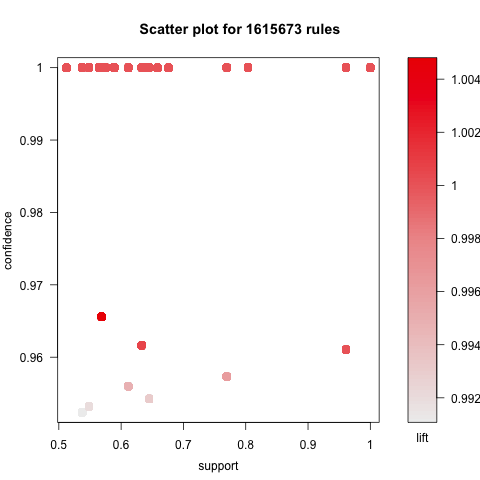

In [56]:

# visualize the different rules, 
#  the first visualization might take some time to render properly
%R library(arulesViz)
%R plot(rules)

In [ ]:

# a great plot
%R plot(rules, method="grouped")
%R inspect(rules)
%R length(rules)

## Summarize the Ramifications

# 4. Deployment

# 5. Exceptional Work